# Main Results
## Numerical Simulation of Perpendicular Dynamics in the NORTH Tokamak
This Interactive Python Notebook presents the main results of the fluid simulation of North.

In [390]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## Load in Data

In [391]:
from boutdata import collect
from boutdata.data import BoutData
from boututils.datafile import DataFile
import re
import os

job_ids = [re.search('(\d){7}', dir).group() for dir in os.listdir("./shared/NORTH/") if re.search('data_(\d){7}', dir)]
job_ids.sort()
# job_id = job_ids[-1]
job_id = '5703369'
# job_id = '5703257' # Unstable run, but interesting!
# job_id = '5703126' # Best run without vorticity source, but with both global and wall vort sink.
# job_id = '5698085' # Best run without vorticity sinks
print('job_id', job_id)
path = './shared/NORTH/data_' + job_id + '/'

job_id 5703369


In [392]:
bdata = BoutData(path)
outputs = bdata['outputs']
field_keys = outputs.keys()
options = bdata['options']

/home/niflheim/s173965/local/venv/north-simulation/lib64/python3.6/site-packages/boutdata/data.py:769: AlwaysWarning: While building x, y, z coordinate arrays, an exception occured: name 'mxg' is not defined
Evaluating non-scalar options not available
  + "\nEvaluating non-scalar options not available"


In [393]:
def get_option(*keys):
    from numpy import sqrt, pi
    from ast import parse, walk, Name
    val = options
    group = keys[0]
    for key in keys:
        val = val[key]
    try:
        return eval(str(val))
    except:
        # Parse undefined variables from the Bout.inp file:
        val_str = str(val).replace(':', '____') # Replace group indicator ':' with '____' to make string parsable.
        for node in walk(parse(val_str)):
            if type(node) is Name:
                missing_keys = node.id.split('____')
                var = missing_keys[-1]
                if var not in locals():
                    try:
                        locals()[var] = get_option(*missing_keys)
                    except:
                        missing_keys.insert(0, group)
                        try:
                            locals()[var] = get_option(*missing_keys)
                        except:
                            print('Error reading option for keys: ', keys)
                            return 0
        return eval(str(val))

def get_options(keys_list):
    vals = []
    for keys in keys_list:
        vals.append(get_option(*keys))
    return vals

In [394]:
oci, rho_s, R, a, n0, Te0, e, n_n, E_ion, mxg, myg, nx_all, ny_all, nz_all = get_options([
    ('north', 'oci'), ('north', 'rho_s'), ('north', 'R'), ('north', 'a'), ('north', 'n0'), ('north', 'Te0'), ('north', 'e'), ('north', 'n_n'), ('north', 'E_ion'),
    ('mxg',), ('myg',),
    ('mesh', 'nx'),('mesh', 'ny'),('mesh', 'nz')])
Lx = a/rho_s * rho_s
nx_inner = nx_all - 2*mxg
ny_inner = ny_all - 2*myg
nz_inner = nz_all

In [395]:
# %% Read data. 
cache_data = './cached_data/data_' + job_id + '.npz'

if os.path.exists(cache_data):
    data_tot = np.load(cache_data, allow_pickle=True)['data_tot'].item()
else:
    # Uncomment this cell to load data in and cache it anew.
    key_list  = ['t_array', 'B', 'T', 'n', 'phi', 'vort', 'source_T', 'wall_shadow']

    data_tot = {}
    for key in key_list:
        data_tot[key] = collect(key, path = path, xguards = False, info=False)

    # Calculate Pressure and Ionization Source
    data_tot['p'] = data_tot['n'] * data_tot['T']

    def k_ionization(T):
        return 2.0e-13*np.sqrt(T/E_ion)/(6.0 + T/E_ion)*np.exp(-E_ion/T)*n0/(oci)
    data_tot['S_n'] = n_n*data_tot['n']*k_ionization(data_tot['T'])

    # Cach data
    np.savez(cache_data, data_tot=data_tot)

In [7]:
times_tot = data_tot['t_array']/oci

# Set maximum time for analysis (s)
# (in case the simulation time is unnecessary long)
time_end = np.min([times_tot[-1], 3300*10**(-6)]) 

# Uncomment line below to use all simulated data points
# time_end = times_tot[-1]

# Save seperate variables for transient, ´
# steady state and all time behaviour
# so that we can analyze them individually.

# Time in seconds of shift from transient
# to steady state behaviour. Set by
# looking at the animation of n.
time_trans = 1300*10**(-6)

times = times_tot[times_tot <= time_end]
times_trans = times_tot[times_tot <= time_trans]
times_ss = times_tot[np.all([time_trans < times_tot, times_tot <= time_end], axis=0)]

data, data_trans, data_ss = {}, {}, {}
for key in data_tot.keys():
    if len(data_tot[key].shape) > 0 and data_tot[key].shape[0] == data_tot['t_array'].shape[0]:
        i_data = np.where(times_tot <= time_end)
        i_trans = np.where(times_tot <= time_trans)
        i_ss = np.where(np.all([time_trans < times_tot, times_tot <= time_end], axis=0))
        data[key] = np.take(data_tot[key], i_data, axis=0).squeeze()
        data_trans[key] = np.take(data_tot[key], i_trans, axis=0).squeeze()
        data_ss[key] = np.take(data_tot[key], i_ss, axis=0).squeeze()
    else:
        data[key] = data_tot[key]
        data_trans[key] = data_tot[key]
        data_ss[key] = data_tot[key]

In [8]:
# Save simulation coordinates for plotting
# theta-angles and
# rho (toroidal (inner) radius coordinate) and
# times
thetas = np.linspace(0, 2 * np.pi, nz_inner)
rhos = np.linspace(Lx/(2*nx_inner), Lx+Lx/(2*nx_inner), nx_inner)
times = data['t_array']/oci

## Plots of the Fields

### Time Frames Plots

In [122]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})
rcParams['axes.titlepad'] = 20

from matplotlib.gridspec import GridSpec

def cbar_ticks(vmin, vmax, n_ticks=4, label_rounding=3):
    ticks = np.linspace(vmin, vmax, n_ticks, endpoint=True)
    labels = np.round(ticks,label_rounding)
    return ticks, labels

def plot_time_frames(data=data, start_frame=0, end_frame=None, resolution=2):
    fields = ['n', 'T', 'vort', 'phi']
    cmaps = ['inferno', 'inferno', 'jet', 'jet']
    titles = [r'$n$', r'$T$', r'$\Omega$', r'$\phi$']
    N_frames = 6
    cm = 1/2.54 # 1 cm = 1/2.54 inch
    nrows = 5*N_frames + 1 # 5 (merged rows) for each frame plot. 1 row for colobar
    n_cols = 1 + len(fields)*6 # 1 column for each timestamp text. 3 (merged columns) for each field plot.
    fig = plt.figure(constrained_layout=True, figsize=(16*cm, 20*cm))
    gs = GridSpec(nrows, n_cols, figure=fig)
    def get_row_range(i_frame):
        return slice(5*i_frame,5*(i_frame+1))
    def get_col_range(i_field):
        return slice(1+6*i_field,1+6*(i_field+1))
    if end_frame is None:
        end_frame = data[fields[0]].shape[0]
    frames = np.linspace(start_frame, end_frame - 1, N_frames, dtype=int)
    # frames = np.arange(start_frame, end_frame, int(np.ceil(end_frame/N_frames)))

    for i_frame, frame in enumerate(frames):
        row_range = get_row_range(i_frame)
        ax = fig.add_subplot(gs[row_range, 0])
        ax.text(0.5, 0.5, r'$t = ' + str(round(times[frame]*(10**6),1)) + '\, \mathrm{\mu \, s}$', va="center", ha="center")
        plt.axis('off')

    for i_field, field in enumerate(fields):
        field_data = data[field].squeeze()
        vmin = field_data.min()
        vmax = field_data.max()
        col_range = get_col_range(i_field)
        for i_frame, frame in enumerate(frames):
            row_range = get_row_range(i_frame)
            ax = fig.add_subplot(gs[row_range, col_range], polar=True)
            if i_frame == 0:
                ax.set_title(titles[i_field])
            cont = ax.contourf(thetas, rhos, field_data[frame, :, :], resolution, cmap = cmaps[i_field], vmin=vmin, vmax=vmax)
            ax.set_rticks([])
            ax.set_xticks([])

        cax = fig.add_subplot(gs[-1, col_range])
        latest = field_data[frames[-1], :, :]
        c_ticks, c_labels = cbar_ticks(latest.min(), latest.max())
        cbar = fig.colorbar(cont, cax=cax, ticks=c_ticks, orientation='horizontal')
        cax.set_title(titles[i_field] + ' [norm. units]')
        cbar.ax.set_xticklabels(c_labels, rotation=45)
    return fig

# fig = plot_time_frames(resolution=2)
# plt.show()

# # # Uncomment this section to save plot time frames
# # # fig.savefig('./plots/' + job_id + '_time_frames.pdf', format="pdf", bbox_inches="tight")
# # fig.savefig('./plots/' + job_id + '_time_frames.png', dpi=600)

In [123]:
# fig = plot_time_frames(end_frame=20, resolution=30)
# plt.show()

# # Uncomment this section to save plot time frames
# # fig.savefig('./plots/' + job_id + '_time_frames.pdf', format="pdf", bbox_inches="tight")
# fig.savefig('./plots/' + job_id + '_time_frames_trans.png', dpi=600)

### Gif Animations of plots

In [93]:
import matplotlib.animation as animation

def get_cmap(cmap, min_p=0.0, N_cmap=256):
    cmap = plt.get_cmap(cmap)
    return ListedColormap(cmap(np.linspace(0,1,int(N_cmap/(1-min_p))))[-N_cmap:,:])

def get_cbar_mappable(cmap, vmin, vmax):
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    return mpl.cm.ScalarMappable(norm=norm, cmap=get_cmap(cmap))

def get_extend(field_data, vmin, vmax):
    if field_data.min() < vmin and vmax >= field_data.max():
        return 'min'
    elif field_data.min() <= vmin and vmax < field_data.max():
        return 'max'
    elif field_data.min() < vmin and vmax < field_data.max():
        return 'both'
    else:
        return 'neither'

def plot_first_frame(field, cmap, vmin = None, vmax = None, frame=0, clabel = None, title=None):
    field_data = data[field].squeeze()
    if vmin is None:
        vmin = field_data.min()
    if vmax is None:
        vmax = field_data.max()
    if clabel is None:
        clabel = r'$' + field + '$ [norm. u.]'
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    if title is not None:
        ax.set_title(title)
    ax.set_rticks([])
    ax.set_xticks([])
    ax.contourf(thetas, rhos, field_data[frame, :, :], 100, cmap = cmap, vmin=vmin, vmax=vmax)    # first image on screen
    txt = ax.text(0.5, -0.15, r'$t = ' + str(round(times[0]*(10**6),0)) + '\, \mathrm{\mu \, s}$', va="center", ha="center", transform=ax.transAxes)
    # ax.subtitle(r'$t = ' + 0 + '\, \mathrm{\mu s}$')
    fig.colorbar(get_cbar_mappable(cmap, vmin, vmax), orientation='vertical', label=clabel, extend=get_extend(field_data, vmin, vmax), ax=ax)
    fig.tight_layout()
    return fig, ax, txt, field_data, vmin, vmax

def animate_data(field, cmap='inferno', vmin = None, vmax = None, clabel=None, title=None):
    fig, ax, txt, field_data, vmin, vmax = plot_first_frame(field, cmap, vmin, vmax, clabel=clabel, title=title)

    # animation function
    def animate(i):
        for c in ax.collections:
            c.remove()  # removes only the contours, leaves the rest intact
        cont = ax.contourf(thetas, rhos, field_data[i, :, :], 100, cmap = cmap, vmin=vmin, vmax=vmax)
        txt.set_text(r'$t = ' + str(round(times[i]*(10**6))) + '\, \mathrm{\mu \, s}$')
        return cont.collections
    
    anim = animation.FuncAnimation(fig, animate, frames=field_data.shape[0], interval=100, blit=True)
    anim.save('./plots/' + job_id + '_animation_' + field +'.gif', fps=4, dpi=300)
    plt.show()

In [94]:
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

MovieWriter ffmpeg unavailable; using Pillow instead.


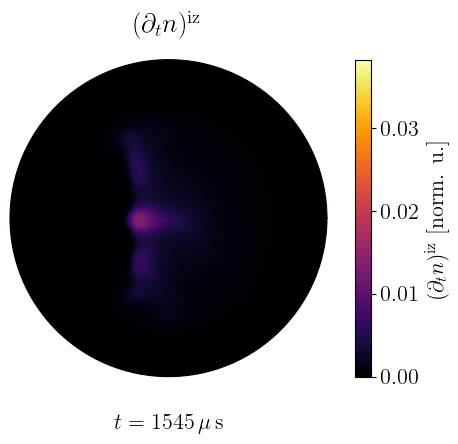

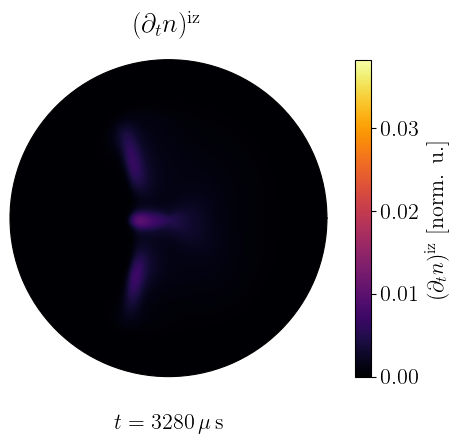

In [127]:
animate_data('S_n', vmax=np.quantile(data['S_n'], 1.0), clabel=r'$(\partial_t n)^{\mathrm{iz}}$ [norm. u.]', title=r'$(\partial_t n)^{\mathrm{iz}}$')

MovieWriter ffmpeg unavailable; using Pillow instead.


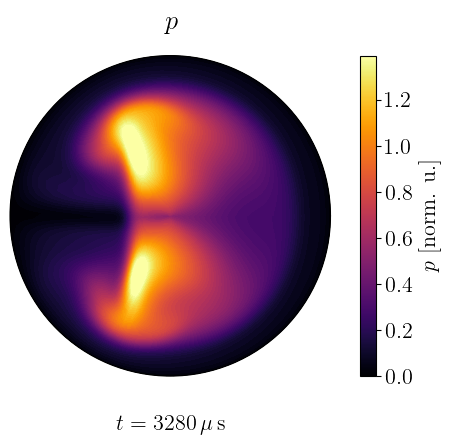

In [128]:
animate_data('p', vmin=0, vmax=np.quantile(data['p'], 0.99), clabel=r'$p$ [norm. u.]', title=r'$p$')

MovieWriter ffmpeg unavailable; using Pillow instead.


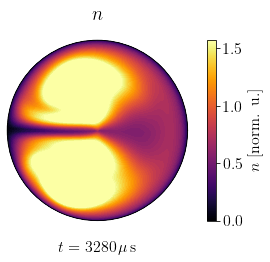

In [95]:
animate_data('n', vmin=0, vmax=np.quantile(data['n'], 0.8), clabel=r'$n$ [norm. u.]', title=r'$n$')

MovieWriter ffmpeg unavailable; using Pillow instead.


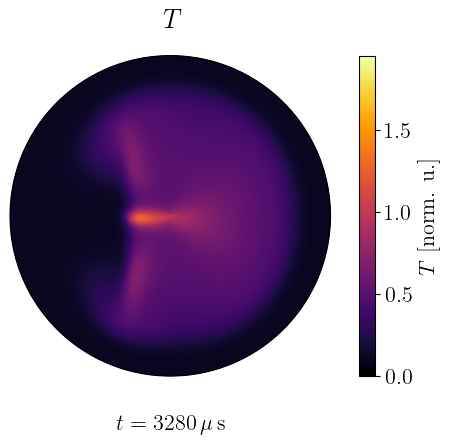

In [129]:
animate_data('T', vmin=0, vmax=np.quantile(data['T'], 0.995), clabel=r'$T$ [norm. u.]', title=r'$T$')

MovieWriter ffmpeg unavailable; using Pillow instead.


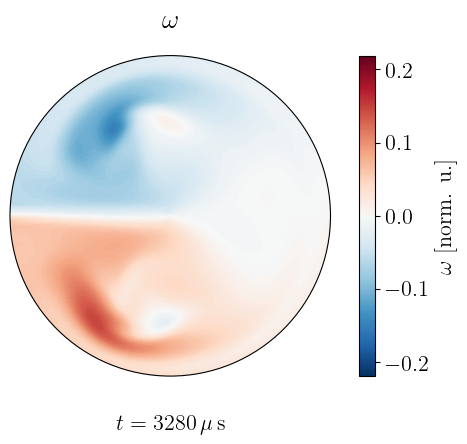

In [130]:
# Set vmin and vmax to symmetrise around 0
vmax = np.max([data['vort'].max(), np.abs(data['vort'].min())])
vmin = -vmax

animate_data('vort', cmap='RdBu_r', vmin=vmin, vmax=vmax, clabel=r'$\omega$ [norm. u.]', title=r'$\omega$')

MovieWriter ffmpeg unavailable; using Pillow instead.


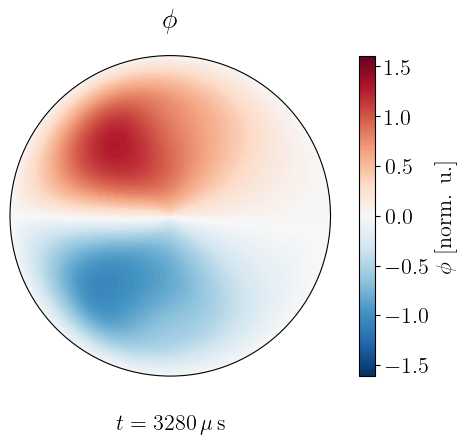

In [131]:
# Set vmin and vmax to symmetrise around 0
vmax = np.max([data['phi'].max(), np.abs(data['phi'].min())])
vmin = -vmax

animate_data('phi', cmap='RdBu_r', vmin=vmin, vmax=vmax, clabel=r'$\phi$ [norm. u.]', title=r'$\phi$')

## Time Series of Volume Integrals

In [14]:
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [15]:
# Define Jacobian
mesh_t, mesh_rhos, mesh_thetas = np.meshgrid(times, rhos, thetas, indexing='ij')
mesh_t.shape, mesh_rhos.shape, mesh_thetas.shape

Jfun = lambda t, r, theta: np.abs(r*(R + r*np.cos(theta)))

# plt.contour(thetas, rhos, Jfun(mesh_t, mesh_rhos, mesh_thetas)[0, :, :], 40, cmap='jet')
# plt.colorbar()

# Calculate Torus Volume:
V = 2*np.pi*np.trapz(np.trapz(Jfun(mesh_t, mesh_rhos, mesh_thetas)[0,:,:], rhos, axis=0), thetas, axis=0)
print('test of Jacobian. Volume of torus is: ' + str(round(V,4)) + ' m^3')

test of Jacobian. Volume of torus is: 0.0787 m^3


In [16]:
def int_dV(field_data):
    '''Calculate volume integral of field_data'''
    J = Jfun(mesh_t, mesh_rhos, mesh_thetas)
    return 2*np.pi*np.trapz(np.trapz(J*field_data, rhos, axis=1), thetas, axis=1)

In [17]:
# Calculate energy
def energy():
    n = data['n'].squeeze()*n0
    T = data['T'].squeeze()*Te0
    return int_dV((3/2)*n*T)

E = energy()

### Density

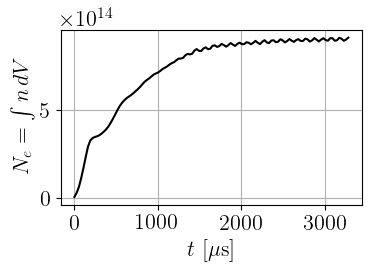

In [18]:
N_e = int_dV(data['n'].squeeze()*n0)
plt.figure(figsize=(4,3))
plt.plot(times*(10**6), N_e, 'k-')
plt.xlabel(r'$t$  $[\mathrm{\mu s}]$')
plt.ylabel(r'$N_e = \int n \, dV$')
plt.grid()
plt.tight_layout()
plt.savefig('./plots/' + job_id + '_N_e.png', dpi=300)
plt.savefig('./plots/' + job_id + '_N_e.pdf')
plt.show()

### Temperature

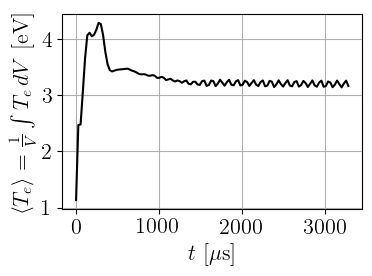

In [19]:
T_mean = int_dV(data['T'].squeeze()*Te0) / V
plt.figure(figsize=(4,3))
plt.plot(times*(10**6), T_mean, 'k-')
plt.xlabel(r'$t$  $[\mathrm{\mu s}]$')
plt.ylabel(r'$\left< T_e \right> = \frac{1}{V} \int T_e \, dV$ [eV]')
plt.grid()
plt.tight_layout()
plt.savefig('./plots/' + job_id + '_T_mean.png', dpi=300)
plt.savefig('./plots/' + job_id + '_T_mean.pdf')
plt.show()

### Energy

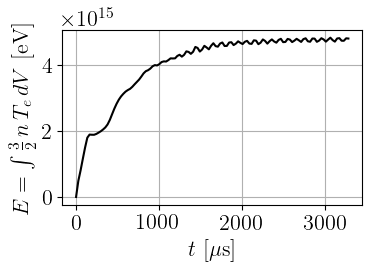

In [20]:
# Calculate energy
def energy():
    n = data['n'].squeeze()*n0
    T = data['T'].squeeze()*Te0
    return int_dV((3/2)*n*T)

E = energy()

plt.figure(figsize=(4,3))
plt.plot(times*(10**6), E, 'k-')
plt.xlabel(r'$t$  $[\mathrm{\mu s}]$')
plt.ylabel(r'$E = \int \frac{3}{2} \, n \, T_e \, dV$  $\mathrm{[eV]}$')
plt.grid()
plt.tight_layout()
plt.savefig('./plots/' + job_id + '_energy.png', dpi=300)
plt.savefig('./plots/' + job_id + '_energy.pdf')
plt.show()

In [21]:
P_ext = 1/e # External heating source in eV/s

# Energy confinement estimate
tau_E = float(np.mean(E[times*10**6 >= 1500])/P_ext)

print('Estimated confinement time = ' + str(round(tau_E * 10**3, 3)) + ' ms')

Estimated confinement time = 0.753 ms


## Radial Profiles

In [22]:
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [23]:
def get_radial_profile(field, theta=0):
    N_theta = len(thetas)
    field_data = np.mean(data[field], axis=0).squeeze()
    field_data_inv = np.flip(field_data[:,(theta + int(N_theta/2)) % N_theta])
    # x = np.hstack([-np.flip(rhos), rhos])
    x = np.linspace(-1,1,field_data.shape[0]*2)
    radial_field = np.hstack((field_data_inv, field_data[:,theta]))

    return x, radial_field

def plot_radial_profile(field, ylabel, theta=0):
    x, radial_field = get_radial_profile(field, theta=theta)
    plt.figure(figsize=(4,3))
    plt.plot(x, radial_field, 'k-')
    plt.xlabel(r'$(R - R_0)/a$')
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()
    plt.savefig('./plots/' + job_id + '_radial_' + field + '.png', dpi=300)
    plt.savefig('./plots/' + job_id + '_radial_' + field + '.pdf')
    plt.show()

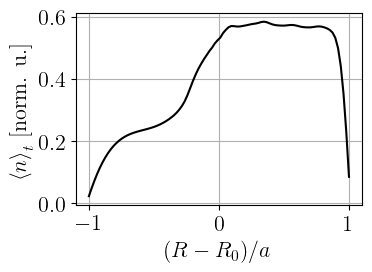

In [25]:
plot_radial_profile('n', ylabel=r'$\left< n \right>_t$ [norm. u.]')

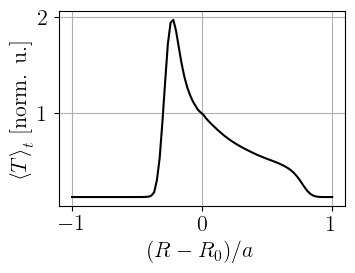

In [26]:
plot_radial_profile('T', r'$\left< T \right>_t$ [norm. u.]')

## Fast Probes

In [42]:
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [146]:
cache_fast = './cached_data/fast_' + job_id + '.npz'

if os.path.exists(cache_fast):
    fast = np.load(cache_fast, allow_pickle=True)['fast'].item()
else:
    fast = {}
    for file in [f for f in os.listdir(path) if 'BOUT.fast' in f]:
        dir = path + file
        fast_data = DataFile(dir)
        for key in fast_data.keys():
            for search_pattern in ['t_array', 'n\d', 'T\d', 'phi\d']:
                match = re.search(search_pattern, key)
                if match:
                    fast[match.string] = fast_data[match.string]

    # Cach fast data
    np.savez(cache_fast, fast=fast)

times_fast = fast['t_array']/oci

In [44]:
N_probes = len([k for k in fast.keys() if re.search('n(\d.*)', k)])
n_fast = []
for i in range(N_probes):
    n_fast.append(fast['n' + str(i)])

probe_pos_bout_norm = np.array([0.05, 0.14, 0.23, 0.32, 0.41, 0.50, 0.59, 0.68, 0.77, 0.86, 0.95])
probe_pos = probe_pos_bout_norm*a

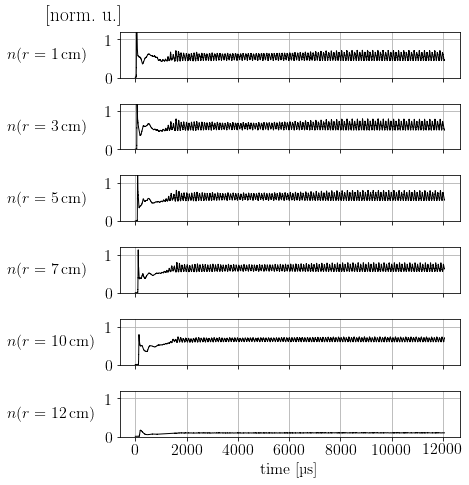

In [297]:
N_plots = int(np.ceil(N_probes/2)) # number of plots
probe_range = range(0, N_probes, 2) # Range (indices) of probes to plot

fig, ax  = plt.subplots(N_plots, 1, figsize=(7, 7), sharex=True)
t_max = times_fast[-1]
for i_plot, i_probe in enumerate(probe_range):
    n_probe = n_fast[i_probe]
    ax[i_plot].plot(times_fast[times_fast < t_max]*10**6, n_probe[times_fast < t_max], 'k', label=r'$n(r=' + str(round(probe_pos[i_probe]*100)) + ' \, \mathrm{cm})$', linewidth=1.0)
    # ax[i_plot].set_title(r'$n(r=' + str(round(probe_pos[i_probe]*100)) + ' \, \mathrm{cm})$', x=-0.1, y=0.5)
    # ax[i_plot].legend(bbox_to_anchor=(-0.05,0.5), loc='center right', ncol=1)
    ax[i_plot].annotate(r'$n(r=' + str(round(probe_pos[i_probe]*100)) + ' \, \mathrm{cm})$', (-5000,0.5), annotation_clip=False)
    ax[i_plot].grid()
    ax[i_plot].set_ylim(0,1.2)
    ax[i_plot].set_yticks([0,1])
ax[-1].set_xlabel('time [µs]')
ax[0].set_title('[norm. u.]', x=-0.1, y=0.8)
fig.tight_layout()
plt.show()
fig.savefig('./plots/' + job_id + '_n_probes_all_times.pdf')
fig.savefig('./plots/'  + job_id + '_n_probes_all_times.png', dpi=300)

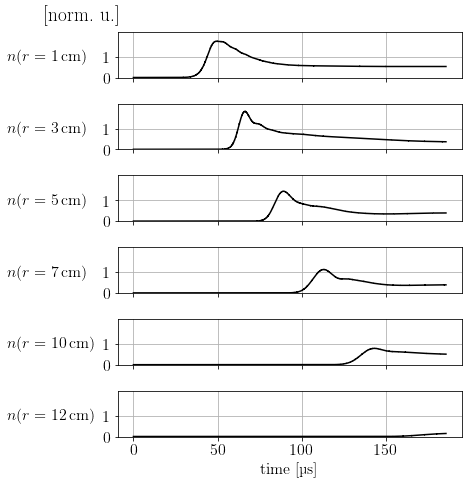

In [299]:
N_plots = int(np.ceil(N_probes/2)) # number of plots
probe_range = range(0, N_probes, 2) # Range (indices) of probes to plot

fig, ax  = plt.subplots(N_plots, 1, figsize=(7, 7), sharex=True)
t_max = time_trans/7
for i_plot, i_probe in enumerate(probe_range):
    n_probe = n_fast[i_probe]
    ax[i_plot].plot(times_fast[times_fast < t_max]*10**6, n_probe[times_fast < t_max], 'k', label=r'$n(r=' + str(round(probe_pos[i_probe]*100)) + ' \, \mathrm{cm})$')
    # ax[i_plot].set_title(r'$n(r=' + str(round(probe_pos[i_probe]*100)) + ' \, \mathrm{cm})$', x=-0.1, y=0.5)
    # ax[i_plot].legend(bbox_to_anchor=(-0.05,0.5), loc='center right', ncol=1)
    ax[i_plot].annotate(r'$n(r=' + str(round(probe_pos[i_probe]*100)) + ' \, \mathrm{cm})$', (-75,0.82), annotation_clip=False)
    ax[i_plot].grid()
    ax[i_plot].set_ylim(0,2.2)
    ax[i_plot].set_yticks([0,1])
ax[-1].set_xlabel('time [µs]')
ax[0].set_title('[norm. u.]', x=-0.1, y=0.8)
fig.tight_layout()
plt.show()
fig.savefig('./plots/' + job_id + '_n_probes_transient.pdf')
fig.savefig('./plots/'  + job_id + '_n_probes_transient.png', dpi=300)

In [300]:
t_min = time_trans
t_max = time_end
t_filter = np.all([t_min <= times_fast, times_fast < t_max], axis=0)

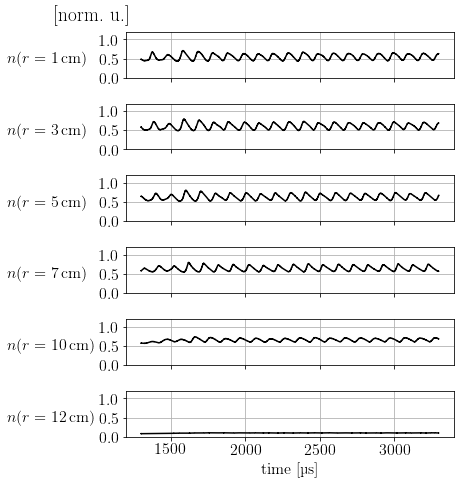

In [302]:
N_plots = int(np.ceil(N_probes/2)) # number of plots
probe_range = range(0, N_probes, 2) # Range (indices) of probes to plot

fig, ax  = plt.subplots(N_plots, 1, figsize=(7, 7), sharex=True)

for i_plot, i_probe in enumerate(probe_range):
    n_probe = n_fast[i_probe]
    ax[i_plot].plot(times_fast[t_filter]*10**6, n_probe[t_filter], 'k', label=r'$n(r=' + str(round(probe_pos[i_probe]*100)) + ' \, \mathrm{cm})$')
    # ax[i_plot].set_title(r'$n(r=' + str(round(probe_pos[i_probe]*100)) + ' \, \mathrm{cm})$', x=-0.1, y=0.5)
    # ax[i_plot].legend(bbox_to_anchor=(-0.05,0.5), loc='center right', ncol=1)
    ax[i_plot].annotate(r'$n(r=' + str(round(probe_pos[i_probe]*100)) + ' \, \mathrm{cm})$', (t_min*10**6 - 900,0.4), annotation_clip=False)
    ax[i_plot].grid()
    ax[i_plot].set_ylim(0,1.2)
    ax[i_plot].set_yticks([0, 0.5, 1])
ax[-1].set_xlabel('time [µs]')
ax[0].set_title('[norm. u.]', x=-0.1, y=0.8)
fig.tight_layout()
plt.show()
fig.savefig('./plots/' + job_id + '_n_probes_ss.pdf')
fig.savefig('./plots/'  + job_id + '_n_probes_ss.png', dpi=300)

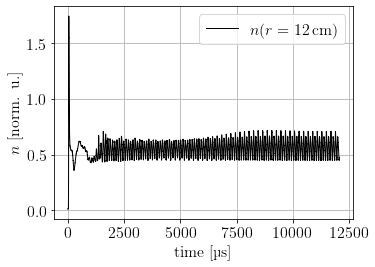

In [389]:
plt.figure(figsize=(5.5,4))
plt.plot(times_fast*10**6, n_fast[0], 'k', label=r'$n(r=' + str(round(probe_pos[i_probe]*100)) + ' \, \mathrm{cm})$', linewidth=1.0)
plt.grid()
plt.legend()
plt.xlabel('time [µs]')
plt.ylabel(r'$n$ [norm. u.]')
plt.tight_layout()
plt.savefig('./plots/' + job_id + '_n0_all_time.pdf')
plt.savefig('./plots/' + job_id + '_n0_all_time.png')

In [384]:
# Sample signal with constant sample frequency
from scipy import interpolate

dt = np.max(np.diff(times_fast))
fs = 1/dt
print('Sampling Frequency is ' + str(np.round(fs*10**(-6),3)) + ' MHz')
t_sampled = np.arange(t_min, t_max, dt)

n0_interp = interpolate.interp1d(times_fast, n_fast[0])
n0_sampled = n0_interp(t_sampled)
n0_sampled_stand = n0_sampled - np.mean(n0_sampled)
N_n0 = len(n0_sampled)

Sampling Frequency is 0.743 MHz


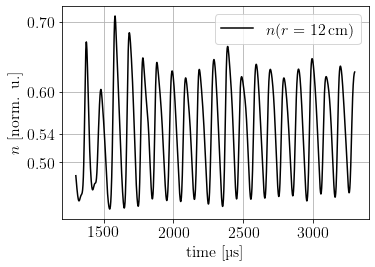

In [386]:
# Plot steady state signal
n_ss_mean = round(np.mean(n0_sampled),2)
plt.figure(figsize=(5.5,4))
plt.plot(t_sampled*10**6, n0_sampled,'-k', label='$n(r = 12 \, \mathrm{cm})$')
plt.legend()
plt.xlabel('time [µs]')
plt.ylabel(r'$n$ [norm. u.]')
plt.yticks([0.5, n_ss_mean, 0.6, 0.7])
plt.grid()
plt.tight_layout()
plt.savefig('./plots/' + job_id + '_n0_ss.pdf')
plt.savefig('./plots/' + job_id + '_n0_ss.png')


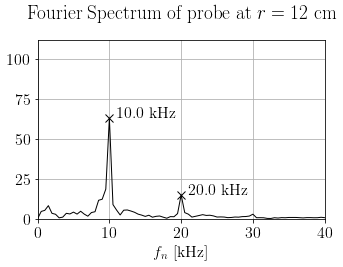

In [371]:
from scipy.signal import find_peaks

f = np.fft.fft(n0_sampled_stand)
freq = np.fft.fftfreq(t_sampled.shape[-1], d=dt)  
F = np.abs(f[:int(len(f)/2)])
Freq = freq[:int(len(f)/2)]
# Freq = freq[:int(N_n0/2)]

peaks, _ = find_peaks(F, prominence=0.5, width=1.0)
big_peaks = peaks[np.argsort(-F[peaks])[:2]]
f_fft = freq[big_peaks]

plt.figure(figsize=(5,4))
plt.plot(Freq*10**(-3), F, '-k', linewidth=1.0)
plt.grid()
plt.xlim(0,40)
plt.xlabel('$f_n \,\, \mathrm{[kHz]}$')
plt.ylim(0,int(np.max(F)+50))
plt.title(r'Fourier Spectrum of probe at $r = ' + str(round(probe_pos[i_probe]*100)) + '$ cm')

for big_peak in big_peaks:
    p_x = Freq[big_peak]*10**(-3)
    p_y = F[big_peak]
    plt.plot(p_x, p_y, "kx", markersize=8)
    plt.annotate(str(np.round(p_x,1)) + ' kHz', xy=(p_x + 1, p_y))

plt.tight_layout()
plt.savefig('./plots/' + job_id + '_fft.pdf')
plt.savefig('./plots/' + job_id + '_fft.png', dpi=300)

In [337]:
# Make fit with first harmonic frequency
from scipy.optimize import curve_fit

f0 = Freq[big_peaks[0]]

def func(tt, A, phi):
    return np.abs(A) * np.sin(2 * np.pi * f0 * tt - phi)

p, pcov = curve_fit(func, t_sampled, n0_sampled_stand)
print(p)

[-0.08476801 -1.92856501]


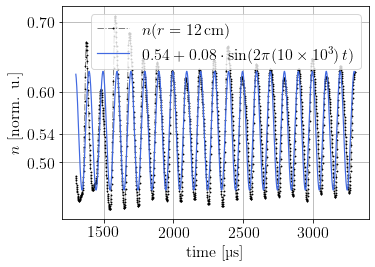

In [385]:
# Plot fit
n_ss_mean = round(np.mean(n0_sampled),2)
plt.figure(figsize=(5.5,4))
plt.plot(t_sampled*10**6, n0_sampled,'-.x', label='$n(r = 12 \, \mathrm{cm})$',linewidth=1.0, color = 'gray', markersize=1.2, markerfacecolor='darkblue',markeredgecolor='black')
plt.plot(t_sampled*10**6, func(t_sampled, p[0], p[1]) + np.mean(n0_sampled), '-',
    label=r'$' + str(n_ss_mean) + ' + ' + str(round(np.abs(p[0]), 2)) + ' \cdot \sin(2 \pi (' + str(round(f0*10**(-3))) + ' \\times 10^{3}) \, t)$',
    linewidth=1.2, color = 'royalblue', markersize=1, markerfacecolor='darkblue', markeredgecolor='k')
plt.legend()
plt.xlabel('time [µs]')
plt.ylabel(r'$n$ [norm. u.]')
plt.yticks([0.5, n_ss_mean, 0.6, 0.7])
plt.grid()
plt.tight_layout()
plt.savefig('./plots/' + job_id + '_n0_ss_with_fit.pdf')
plt.savefig('./plots/' + job_id + '_n0_ss_with_fit.png')
